<a href="https://colab.research.google.com/github/adikulkarni11/Machine-Learning-Models/blob/main/Fashion_MNIST_MLP_Classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  It shares the same image size and structure of training and testing splits.

- ## Here, we build MLP classifiers for the Fashion-MNIST dataset.
- ## We vary the number of neurons in the hidden layers and compare the accuracy results.
- ## Additionally, we use PCA to reduce the dimensionality of the dataset. Make sure we preserve 95% of the explained variance.
- ## Next, we train a classifier using the dimensionality reduced dataset. Record the training time, compare the training time with the training time for the original dataset and the classification accuracy results.
- ## Finally, we follow up and improve the model by fine tuning the neural network hyperparameters using RandomizedSearchCV. Note to use the dataset after the PCA step. This will make this search less time consuming.


In [ ]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [ ]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('', kind='train')
X_test, y_test = mnist_reader.load_mnist('', kind='t10k')

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
y_train.shape

(60000,)

### Labels
Each training and test example is assigned to one of the following labels:

Label	Description
- 0	T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

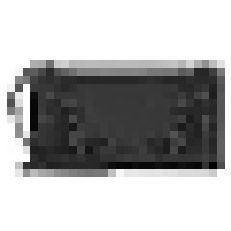

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X_train[36001]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off");

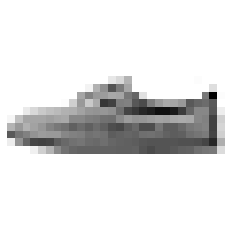

In [ ]:
plot_digit(X_train[40000])

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

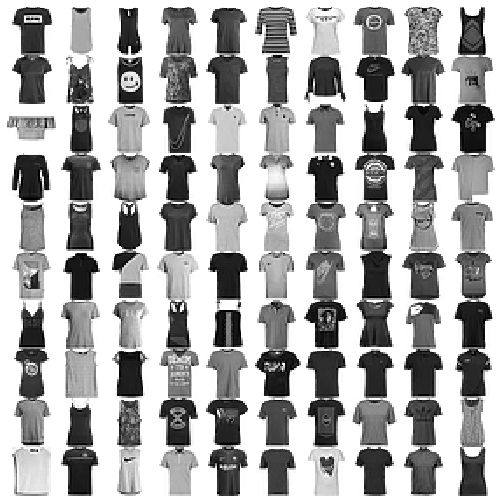

In [ ]:
plt.figure(figsize=(9,9))
X_0 = X_train[(y_train == 0)]
example_images = X_0[:100]
plot_digits(example_images, images_per_row=10)

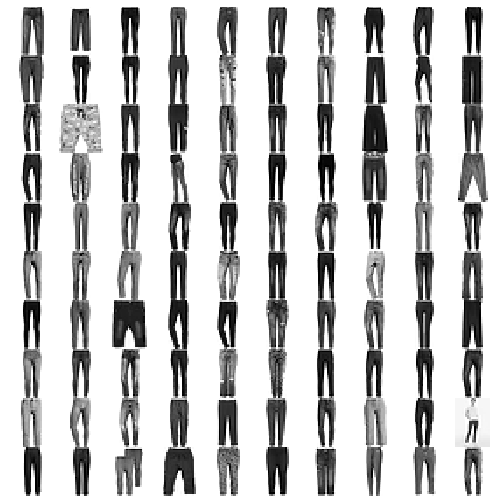

In [ ]:
plt.figure(figsize=(9,9))
X_1 = X_train[(y_train == 1)]
example_images = X_1[:100]
plot_digits(example_images, images_per_row=10)

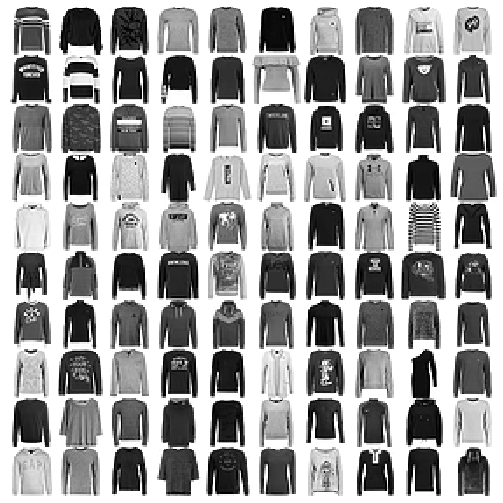

In [ ]:
plt.figure(figsize=(9,9))
X_2 = X_train[(y_train == 2)]
example_images = X_2[:100]
plot_digits(example_images, images_per_row=10)

## Creating the neural network

In [ ]:
X_train_full = X_train
y_train_full = y_train

In [ ]:
X_val, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_val, y_train = y_train_full[:5000], y_train_full[5000:]
#X_val = X_train[:5000] / 255.0
#y_val= y_train[:5000]
X_test = X_test / 255.0

In [ ]:
X_train.shape

(55000, 784)

In [ ]:
X_val.shape

(5000, 784)

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
class_names[y_train[0]]

'Coat'

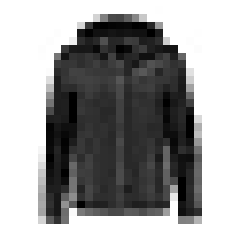

In [ ]:
plot_digit(X_train[0])

Creating the Model

In [ ]:
import tensorflow as tf
from tensorflow import keras

model_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.layers

In [ ]:
hidden1 = model_1.layers[1]

In [ ]:
hidden1.name

'dense'

In [ ]:
model_1.get_layer('dense') is hidden1

True

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

array([[ 0.06970288, -0.06935421,  0.04686018, ...,  0.02930469,
        -0.05915931, -0.01714344],
       [-0.01379166, -0.05639009,  0.02412861, ..., -0.06116631,
        -0.05511371,  0.03076407],
       [ 0.04683861, -0.01137933, -0.00032683, ..., -0.01431436,
         0.01796116, -0.03434618],
       ...,
       [-0.05133308, -0.0440079 ,  0.02036467, ..., -0.03806764,
        -0.02909711, -0.06789339],
       [ 0.03669371,  0.04951371,  0.03642625, ...,  0.05478533,
        -0.02779784, -0.06320799],
       [ 0.04618109,  0.07222906,  0.01668357, ...,  0.01399236,
         0.04435866, -0.01396263]], dtype=float32)

In [ ]:
weights.shape

(784, 300)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
biases.shape

(300,)

Compiling the Model

In [ ]:
model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

In [ ]:
history_1 = model_1.fit(X_train, y_train, epochs=30,
                     validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 5s 97us/sample - loss: 0.7159 - accuracy: 0.7657 - val_loss: 0.5234 - val_accuracy: 0.8246
Epoch 2/30
55000/55000 [==============================] - 5s 90us/sample - loss: 0.4921 - accuracy: 0.8296 - val_loss: 0.4648 - val_accuracy: 0.8416
Epoch 3/30
55000/55000 [==============================] - 5s 87us/sample - loss: 0.4472 - accuracy: 0.8433 - val_loss: 0.4198 - val_accuracy: 0.8616
Epoch 4/30
55000/55000 [==============================] - 5s 86us/sample - loss: 0.4190 - accuracy: 0.8526 - val_loss: 0.4562 - val_accuracy: 0.8340
Epoch 5/30
55000/55000 [==============================] - 5s 92us/sample - loss: 0.3984 - accuracy: 0.8604 - val_loss: 0.3893 - val_accuracy: 0.8700
Epoch 6/30
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3807 - accuracy: 0.8673 - val_loss: 0.3719 - val_accuracy: 0.8748
Epoch 7/30
55000/55000 [==============================] -

In [ ]:
history_1.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [ ]:
print(history_1.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [ ]:
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

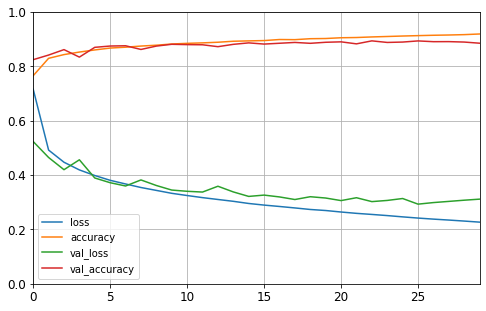

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_1.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 41us/sample - loss: 0.3493 - accuracy: 0.8743


[0.34933723504543307, 0.8743]

#### Varying number of neurons in hidden layers and compare accuracy results:

I trained 4 extra models are varied the number of neurons in them to compare their results.

Model 2:
**Neuron Layers = (30,30, 30)**

In [ ]:
model_2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(30, activation="softmax")
])

In [ ]:
model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])


In [ ]:

history_2 = model_2.fit(X_train, y_train, epochs=30,
                     validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 47us/sample - loss: 1.0020 - accuracy: 0.6646 - val_loss: 0.6056 - val_accuracy: 0.7900
Epoch 2/30
55000/55000 [==============================] - 2s 44us/sample - loss: 0.5732 - accuracy: 0.8000 - val_loss: 0.5108 - val_accuracy: 0.8256
Epoch 3/30
55000/55000 [==============================] - 2s 42us/sample - loss: 0.5091 - accuracy: 0.8229 - val_loss: 0.4702 - val_accuracy: 0.8428
Epoch 4/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.4770 - accuracy: 0.8322 - val_loss: 0.4550 - val_accuracy: 0.8416
Epoch 5/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.4558 - accuracy: 0.8416 - val_loss: 0.4422 - val_accuracy: 0.8500
Epoch 6/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.4406 - accuracy: 0.8450 - val_loss: 0.4353 - val_accuracy: 0.8492
Epoch 7/30
55000/55000 [==============================] -

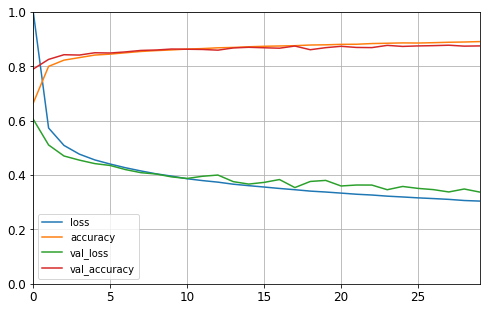

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_2.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 29us/sample - loss: 0.3739 - accuracy: 0.8704


[0.373923282289505, 0.8704]

Model 3:
**Neuron Layers = (30,130, 20)**

In [ ]:
model_3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(130, activation="relu"),
    keras.layers.Dense(20, activation="softmax")
])

In [ ]:
model_3.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])


In [ ]:
history_3 = model_3.fit(X_train, y_train, epochs=30,
                     validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 52us/sample - loss: 0.8893 - accuracy: 0.7065 - val_loss: 0.6454 - val_accuracy: 0.7580
Epoch 2/30
55000/55000 [==============================] - 3s 49us/sample - loss: 0.5485 - accuracy: 0.8070 - val_loss: 0.4846 - val_accuracy: 0.8336
Epoch 3/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4907 - accuracy: 0.8281 - val_loss: 0.4584 - val_accuracy: 0.8408
Epoch 4/30
55000/55000 [==============================] - 3s 49us/sample - loss: 0.4613 - accuracy: 0.8364 - val_loss: 0.4412 - val_accuracy: 0.8492
Epoch 5/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4377 - accuracy: 0.8461 - val_loss: 0.4227 - val_accuracy: 0.8548
Epoch 6/30
55000/55000 [==============================] - 3s 49us/sample - loss: 0.4211 - accuracy: 0.8517 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 7/30
55000/55000 [==============================] -

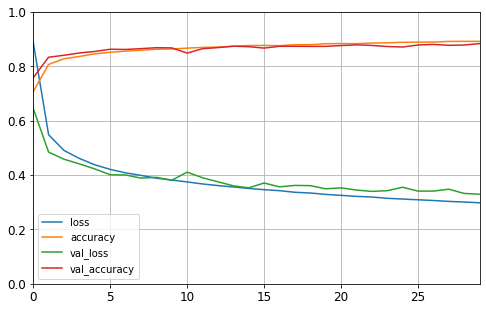

In [ ]:
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_3.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 28us/sample - loss: 0.3651 - accuracy: 0.8675


[0.36510591695308686, 0.8675]

 Model 4:
 **Neuron Layers = (200,200, 200)**

In [ ]:
model_4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(200, activation="softmax")
])

In [ ]:
model_4.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])


In [ ]:
history_4 = model_4.fit(X_train, y_train, epochs=30,
                     validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 5s 83us/sample - loss: 0.8805 - accuracy: 0.7189 - val_loss: 0.5833 - val_accuracy: 0.7946
Epoch 2/30
55000/55000 [==============================] - 4s 78us/sample - loss: 0.5326 - accuracy: 0.8156 - val_loss: 0.4911 - val_accuracy: 0.8258
Epoch 3/30
55000/55000 [==============================] - 5s 82us/sample - loss: 0.4785 - accuracy: 0.8328 - val_loss: 0.4711 - val_accuracy: 0.8366
Epoch 4/30
55000/55000 [==============================] - 4s 76us/sample - loss: 0.4494 - accuracy: 0.8434 - val_loss: 0.4358 - val_accuracy: 0.8560
Epoch 5/30
55000/55000 [==============================] - 4s 80us/sample - loss: 0.4272 - accuracy: 0.8514 - val_loss: 0.4064 - val_accuracy: 0.8610
Epoch 6/30
55000/55000 [==============================] - 4s 80us/sample - loss: 0.4096 - accuracy: 0.8568 - val_loss: 0.3954 - val_accuracy: 0.8604
Epoch 7/30
55000/55000 [==============================] -

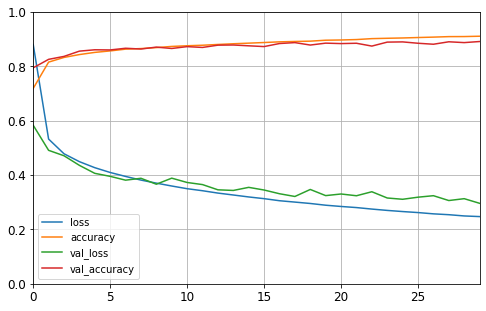

In [ ]:
pd.DataFrame(history_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_4.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 55us/sample - loss: 0.3272 - accuracy: 0.8832


[0.32723132836818697, 0.8832]

 Model 5:
 **Neuron Layers = (50,100, 50)**

In [ ]:
model_5 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="softmax")
])

In [ ]:
model_5.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])


In [ ]:
history_5 = model_5.fit(X_train, y_train, epochs=30,
                     validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 62us/sample - loss: 0.9259 - accuracy: 0.6878 - val_loss: 0.6672 - val_accuracy: 0.7512
Epoch 2/30
55000/55000 [==============================] - 3s 52us/sample - loss: 0.5509 - accuracy: 0.8075 - val_loss: 0.4953 - val_accuracy: 0.8320
Epoch 3/30
55000/55000 [==============================] - 3s 56us/sample - loss: 0.4871 - accuracy: 0.8283 - val_loss: 0.4653 - val_accuracy: 0.8410
Epoch 4/30
55000/55000 [==============================] - 3s 52us/sample - loss: 0.4560 - accuracy: 0.8385 - val_loss: 0.4330 - val_accuracy: 0.8466
Epoch 5/30
55000/55000 [==============================] - 3s 59us/sample - loss: 0.4356 - accuracy: 0.8465 - val_loss: 0.4543 - val_accuracy: 0.8370
Epoch 6/30
55000/55000 [==============================] - 3s 61us/sample - loss: 0.4174 - accuracy: 0.8517 - val_loss: 0.4203 - val_accuracy: 0.8482
Epoch 7/30
55000/55000 [==============================] -

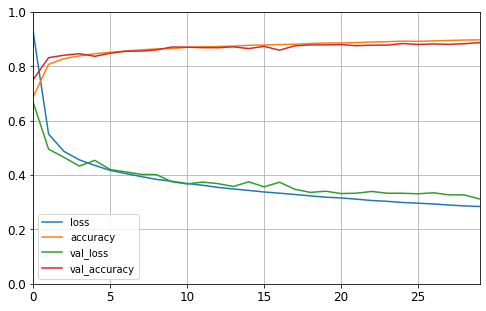

In [ ]:
pd.DataFrame(history_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
model_5.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 35us/sample - loss: 0.3512 - accuracy: 0.8758


[0.3512337387919426, 0.8758]

## Use PCA to reduce the dimensionality of the dataset. 

Making sure we preserve 95% of the explained variance.


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
X_val_reduced = pca.transform(X_val)

In [ ]:
pca.components_

array([[ 9.89746552e-08,  2.22682099e-06,  1.64825803e-05, ...,
         1.08644744e-03,  1.15590519e-04,  1.27938630e-05],
       [-1.55569724e-07,  2.60649640e-06,  3.20728472e-06, ...,
         2.37752671e-03,  7.32560906e-04,  6.68998578e-05],
       [ 5.62757747e-07, -6.11796330e-07,  1.26721485e-05, ...,
        -4.88661556e-04, -9.04138163e-04, -6.76867913e-05],
       ...,
       [-3.57428671e-06,  1.41279934e-05,  1.23018033e-04, ...,
        -4.66266976e-03, -4.86016037e-03, -8.32884868e-04],
       [ 9.25818195e-06,  3.56233467e-05,  1.53545020e-04, ...,
        -9.81502512e-03, -6.94649057e-03, -7.87805948e-04],
       [-8.37858707e-06, -4.80170300e-05, -1.29586819e-04, ...,
         2.03685367e-02,  4.45125691e-03,  1.12590583e-05]])

In [ ]:
pca.explained_variance_ratio_

array([0.2906945 , 0.17714979, 0.06027467, 0.04953692, 0.03831017,
       0.03471921, 0.02347019, 0.0189865 , 0.01350833, 0.013103  ,
       0.00992328, 0.00915551, 0.00765042, 0.00659671, 0.00606268,
       0.00590032, 0.00552631, 0.00524815, 0.00458722, 0.00456821,
       0.00432237, 0.0040515 , 0.0038362 , 0.00371999, 0.00361052,
       0.00351064, 0.00333094, 0.00318973, 0.00308141, 0.00294425,
       0.00275703, 0.00265325, 0.00264008, 0.00255614, 0.00246297,
       0.00236484, 0.0023036 , 0.0022616 , 0.00218772, 0.00209077,
       0.00200412, 0.00196032, 0.00194653, 0.00182901, 0.00174896,
       0.00171713, 0.0016865 , 0.00164676, 0.00161059, 0.00155479,
       0.00152529, 0.00150276, 0.00147183, 0.00143336, 0.00137754,
       0.00137265, 0.00131277, 0.00128911, 0.00127218, 0.00125841,
       0.00121774, 0.00119651, 0.00117945, 0.00116322, 0.00115856,
       0.00112052, 0.00111445, 0.00109867, 0.00105465, 0.00104838,
       0.00103235, 0.00101417, 0.00097863, 0.00095838, 0.00094

## Train a classifier using the dimensionality reduced dataset. Record the training time, compare the training time with the training time for the original dataset. Also compare the classification accuracy results.

#### Training using MLPClassifier

Training whole train dataset

In [ ]:
#Initializing the MLPClassifier
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50),random_state=42,max_iter =30, verbose=3)


In [ ]:
#Fitting the training data to the network
import time
t0 = time.time()
classifier.fit(X_train, y_train)
t1 = time.time()


Iteration 1, loss = 0.59661471
Iteration 2, loss = 0.40222582
Iteration 3, loss = 0.35543678
Iteration 4, loss = 0.33243228
Iteration 5, loss = 0.30887900
Iteration 6, loss = 0.29520988
Iteration 7, loss = 0.28176401
Iteration 8, loss = 0.27143463
Iteration 9, loss = 0.25828078
Iteration 10, loss = 0.25140787
Iteration 11, loss = 0.24302899
Iteration 12, loss = 0.23231085
Iteration 13, loss = 0.22842522
Iteration 14, loss = 0.21833149
Iteration 15, loss = 0.21550192
Iteration 16, loss = 0.21031594
Iteration 17, loss = 0.19979237
Iteration 18, loss = 0.19805217
Iteration 19, loss = 0.19056281
Iteration 20, loss = 0.18302476
Iteration 21, loss = 0.17783939
Iteration 22, loss = 0.17561291
Iteration 23, loss = 0.16986874
Iteration 24, loss = 0.16582845
Iteration 25, loss = 0.16247065
Iteration 26, loss = 0.15617970
Iteration 27, loss = 0.15486513
Iteration 28, loss = 0.14541735
Iteration 29, loss = 0.14328322
Iteration 30, loss = 0.13807098


C:\Users\adiku\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
print("Training time was {:.2f}s".format(t1 - t0))

Training time was 63.94s


In [ ]:
#Predicting y for X_val
y_pred = classifier.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score
x = accuracy_score(y_train, y_pred)

In [ ]:
print("Accuracy Score of MLP Classifier of whole training set = ",x)

Accuracy Score of MLP Classifier of whole training set =  0.9557818181818182


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(classifier,X_train, y_train, cv=3, scoring='accuracy')

Iteration 1, loss = 0.65444101
Iteration 2, loss = 0.42702909
Iteration 3, loss = 0.37967496
Iteration 4, loss = 0.35221468
Iteration 5, loss = 0.33275538
Iteration 6, loss = 0.31260180
Iteration 7, loss = 0.29978642
Iteration 8, loss = 0.29365393
Iteration 9, loss = 0.27280151
Iteration 10, loss = 0.26374034
Iteration 11, loss = 0.25340879
Iteration 12, loss = 0.24817916
Iteration 13, loss = 0.24237578
Iteration 14, loss = 0.22999337
Iteration 15, loss = 0.22522080
Iteration 16, loss = 0.21733266
Iteration 17, loss = 0.20680324
Iteration 18, loss = 0.20583114
Iteration 19, loss = 0.19578677
Iteration 20, loss = 0.19164365
Iteration 21, loss = 0.18810548
Iteration 22, loss = 0.18036665
Iteration 23, loss = 0.17462536
Iteration 24, loss = 0.17267212
Iteration 25, loss = 0.16239505
Iteration 26, loss = 0.16216947
Iteration 27, loss = 0.15412869
Iteration 28, loss = 0.15409284
Iteration 29, loss = 0.14472967
Iteration 30, loss = 0.13849875


C:\Users\adiku\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.66317853
Iteration 2, loss = 0.43059025
Iteration 3, loss = 0.37952580
Iteration 4, loss = 0.35315618
Iteration 5, loss = 0.33047421
Iteration 6, loss = 0.31252399
Iteration 7, loss = 0.29581894
Iteration 8, loss = 0.27964810
Iteration 9, loss = 0.27293293
Iteration 10, loss = 0.26229556
Iteration 11, loss = 0.25853995
Iteration 12, loss = 0.24372472
Iteration 13, loss = 0.23843388
Iteration 14, loss = 0.22917896
Iteration 15, loss = 0.22448044
Iteration 16, loss = 0.21479933
Iteration 17, loss = 0.20742992
Iteration 18, loss = 0.20071694
Iteration 19, loss = 0.19432647
Iteration 20, loss = 0.19647113
Iteration 21, loss = 0.18432893
Iteration 22, loss = 0.18120832
Iteration 23, loss = 0.17830017
Iteration 24, loss = 0.17224151
Iteration 25, loss = 0.16277468
Iteration 26, loss = 0.16116469
Iteration 27, loss = 0.15997656
Iteration 28, loss = 0.15626978
Iteration 29, loss = 0.15093640
Iteration 30, loss = 0.14067640


C:\Users\adiku\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.66391518
Iteration 2, loss = 0.43112965
Iteration 3, loss = 0.37554393
Iteration 4, loss = 0.35514920
Iteration 5, loss = 0.32456594
Iteration 6, loss = 0.30787543
Iteration 7, loss = 0.29615028
Iteration 8, loss = 0.28113521
Iteration 9, loss = 0.27404387
Iteration 10, loss = 0.25754740
Iteration 11, loss = 0.24863077
Iteration 12, loss = 0.24489682
Iteration 13, loss = 0.22950142
Iteration 14, loss = 0.22234212
Iteration 15, loss = 0.21819999
Iteration 16, loss = 0.21251050
Iteration 17, loss = 0.20345070
Iteration 18, loss = 0.20169723
Iteration 19, loss = 0.19254305
Iteration 20, loss = 0.18793287
Iteration 21, loss = 0.18157905
Iteration 22, loss = 0.17656304
Iteration 23, loss = 0.17275281
Iteration 24, loss = 0.16073171
Iteration 25, loss = 0.16548553
Iteration 26, loss = 0.16053566
Iteration 27, loss = 0.14765167
Iteration 28, loss = 0.14190868
Iteration 29, loss = 0.14340027
Iteration 30, loss = 0.13944826


C:\Users\adiku\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([0.89125811, 0.89282208, 0.88744612])

Training reduced train set

In [ ]:
classifier2 = MLPClassifier(hidden_layer_sizes=(150,100,50),random_state=42,max_iter =30, verbose=3)


In [ ]:
t0 = time.time()
classifier2.fit(X_train_reduced, y_train)
t1 = time.time()

Iteration 1, loss = 0.60333690
Iteration 2, loss = 0.33738983
Iteration 3, loss = 0.29685640
Iteration 4, loss = 0.26482869
Iteration 5, loss = 0.24087323
Iteration 6, loss = 0.22314209
Iteration 7, loss = 0.20236225
Iteration 8, loss = 0.18616482
Iteration 9, loss = 0.17172266
Iteration 10, loss = 0.15772018
Iteration 11, loss = 0.14402354
Iteration 12, loss = 0.13330847
Iteration 13, loss = 0.12039781
Iteration 14, loss = 0.10873580
Iteration 15, loss = 0.09882080
Iteration 16, loss = 0.09055036
Iteration 17, loss = 0.08315916
Iteration 18, loss = 0.07476357
Iteration 19, loss = 0.06854480
Iteration 20, loss = 0.06092289
Iteration 21, loss = 0.05511331
Iteration 22, loss = 0.05166892
Iteration 23, loss = 0.04924927
Iteration 24, loss = 0.04398397
Iteration 25, loss = 0.04220347
Iteration 26, loss = 0.03381450
Iteration 27, loss = 0.03852490
Iteration 28, loss = 0.02949378
Iteration 29, loss = 0.02653270
Iteration 30, loss = 0.02459047


C:\Users\adiku\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 34.74s


In [ ]:
#Predicting y for X_val
y_pred = classifier2.predict(X_train_reduced)
m =accuracy_score(y_train, y_pred)

In [ ]:
print("Accuracy score of MLP Classifier with reduced training set is ", m)

Accuracy score of MLP Classifier with reduced training set is  0.9927636363636364


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(classifier2,X_train_reduced, y_train, cv=3, scoring='accuracy')

Iteration 1, loss = 0.70834416
Iteration 2, loss = 0.36210264
Iteration 3, loss = 0.31344092
Iteration 4, loss = 0.28157099
Iteration 5, loss = 0.25495566
Iteration 6, loss = 0.23290476
Iteration 7, loss = 0.21302066
Iteration 8, loss = 0.19195280
Iteration 9, loss = 0.17785998
Iteration 10, loss = 0.15991016
Iteration 11, loss = 0.14710414
Iteration 12, loss = 0.13246842
Iteration 13, loss = 0.12121161
Iteration 14, loss = 0.10818004
Iteration 15, loss = 0.09346423
Iteration 16, loss = 0.08762062
Iteration 17, loss = 0.07891512
Iteration 18, loss = 0.06886756
Iteration 19, loss = 0.06103619
Iteration 20, loss = 0.05609861
Iteration 21, loss = 0.04928696
Iteration 22, loss = 0.04146039
Iteration 23, loss = 0.03755901
Iteration 24, loss = 0.03509542
Iteration 25, loss = 0.03225629
Iteration 26, loss = 0.02731115
Iteration 27, loss = 0.02696164
Iteration 28, loss = 0.02506625
Iteration 29, loss = 0.02326006
Iteration 30, loss = 0.02219038


C:\Users\adiku\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.71215202
Iteration 2, loss = 0.36131354
Iteration 3, loss = 0.31317627
Iteration 4, loss = 0.28150777
Iteration 5, loss = 0.25572807
Iteration 6, loss = 0.23287428
Iteration 7, loss = 0.21489666
Iteration 8, loss = 0.19633909
Iteration 9, loss = 0.17853657
Iteration 10, loss = 0.16301587
Iteration 11, loss = 0.14726584
Iteration 12, loss = 0.13308806
Iteration 13, loss = 0.12121656
Iteration 14, loss = 0.11144745
Iteration 15, loss = 0.09717036
Iteration 16, loss = 0.08574082
Iteration 17, loss = 0.07578623
Iteration 18, loss = 0.06897857
Iteration 19, loss = 0.06477156
Iteration 20, loss = 0.05453062
Iteration 21, loss = 0.04788116
Iteration 22, loss = 0.04222063
Iteration 23, loss = 0.03909382
Iteration 24, loss = 0.03099851
Iteration 25, loss = 0.03032069
Iteration 26, loss = 0.02797323
Iteration 27, loss = 0.02238823
Iteration 28, loss = 0.01959855
Iteration 29, loss = 0.02144880
Iteration 30, loss = 0.02729873


C:\Users\adiku\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.70640393
Iteration 2, loss = 0.36104611
Iteration 3, loss = 0.31305600
Iteration 4, loss = 0.27856851
Iteration 5, loss = 0.25265254
Iteration 6, loss = 0.23240326
Iteration 7, loss = 0.21092392
Iteration 8, loss = 0.19107297
Iteration 9, loss = 0.17454186
Iteration 10, loss = 0.16207149
Iteration 11, loss = 0.14392913
Iteration 12, loss = 0.13259096
Iteration 13, loss = 0.11872839
Iteration 14, loss = 0.10775992
Iteration 15, loss = 0.09597988
Iteration 16, loss = 0.08778915
Iteration 17, loss = 0.07708206
Iteration 18, loss = 0.06738662
Iteration 19, loss = 0.06022113
Iteration 20, loss = 0.05453337
Iteration 21, loss = 0.04954017
Iteration 22, loss = 0.04450685
Iteration 23, loss = 0.04148903
Iteration 24, loss = 0.03477226
Iteration 25, loss = 0.03008193
Iteration 26, loss = 0.02701341
Iteration 27, loss = 0.02590346
Iteration 28, loss = 0.02914063
Iteration 29, loss = 0.02251036
Iteration 30, loss = 0.01414964


C:\Users\adiku\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([0.87833342, 0.87673176, 0.8817175 ])

We observe that time taken to classify the reduced set is suprisingly faster. In addition, we observe that the accuracy does not change by much between the training set and the reduced training set.

## Fine tuning the neural network hyperparameters using RandomizedSearchCV. 

### Reporting using Test Set

#### MLP Classifier

I used the dataset after the PCA step to make this search less time consuming.

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=X_train_reduced.shape[1:]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [ ]:
keras_classifier.fit(X_train_reduced, y_train, epochs=100,
              validation_data=(X_val_reduced, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_classifier.score(X_test_reduced, y_test)


Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 2s 40us/sample - loss: 1.3595 - accuracy: 0.5367 - val_loss: 0.8954 - val_accuracy: 0.7320
Epoch 2/100
55000/55000 [==============================] - 2s 32us/sample - loss: 0.7941 - accuracy: 0.7472 - val_loss: 0.6916 - val_accuracy: 0.7770
Epoch 3/100
55000/55000 [==============================] - 2s 32us/sample - loss: 0.6658 - accuracy: 0.7748 - val_loss: 0.6103 - val_accuracy: 0.7942
Epoch 4/100
55000/55000 [==============================] - 2s 36us/sample - loss: 0.6034 - accuracy: 0.7906 - val_loss: 0.5642 - val_accuracy: 0.8082
Epoch 5/100
55000/55000 [==============================] - 2s 32us/sample - loss: 0.5646 - accuracy: 0.8029 - val_loss: 0.5333 - val_accuracy: 0.8210
Epoch 6/100
55000/55000 [==============================] - 2s 32us/sample - loss: 0.5374 - accuracy: 0.8106 - val_loss: 0.5118 - val_accuracy: 0.8266
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 2s 34us/sample - loss: 0.3562 - accuracy: 0.8732 - val_loss: 0.3667 - val_accuracy: 0.8722
Epoch 56/100
55000/55000 [==============================] - 3s 49us/sample - loss: 0.3552 - accuracy: 0.8736 - val_loss: 0.3656 - val_accuracy: 0.8736
Epoch 57/100
55000/55000 [==============================] - 3s 52us/sample - loss: 0.3541 - accuracy: 0.8746 - val_loss: 0.3664 - val_accuracy: 0.8728
Epoch 58/100
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3533 - accuracy: 0.8744 - val_loss: 0.3652 - val_accuracy: 0.8730
Epoch 59/100
55000/55000 [==============================] - 2s 39us/sample - loss: 0.3524 - accuracy: 0.8749 - val_loss: 0.3643 - val_accuracy: 0.8720
Epoch 60/100
55000/55000 [==============================] - 3s 64us/sample - loss: 0.3514 - accuracy: 0.8753 - val_loss: 0.3645 - val_accuracy: 0.8740
Epoch 61/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.3506 - ac

In [ ]:
y_pred = keras_classifier.predict(X_test_reduced[:3])

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}


rnd_search_cv = RandomizedSearchCV(keras_classifier, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_reduced, y_train, epochs=100,
                 validation_data=(X_val_reduced, y_val),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 36666 samples, validate on 5000 samples
Epoch 1/100
36666/36666 [==============================] - 2s 50us/sample - loss: 2.2448 - accuracy: 0.1762 - val_loss: 2.1206 - val_accuracy: 0.3142
Epoch 2/100
36666/36666 [==============================] - 2s 46us/sample - loss: 2.0105 - accuracy: 0.4149 - val_loss: 1.8898 - val_accuracy: 0.5016
Epoch 3/100
36666/36666 [==============================] - 2s 43us/sample - loss: 1.7724 - accuracy: 0.5368 - val_loss: 1.6371 - val_accuracy: 0.5804
Epoch 4/100
36666/36666 [==============================] - 2s 45us/sample - loss: 1.5219 - accuracy: 0.6007 - val_loss: 1.3904 - val_accuracy: 0.6344
Epoch 5/100
36666/36666 [==============================] - 2s 46us/sample - loss: 1.3011 - accuracy: 0.6453 - val_loss: 1.1959 - val_accuracy: 0.6676
Epoch 6/100
36666/36666 [==============================] - 2s 46us/sample - loss: 1.1371 - accuracy: 0.6739 - val_loss: 1.0593 - val_accuracy: 0.6920
Epoch 7/100
36666/36666 [==========================

Epoch 55/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.4772 - accuracy: 0.8264 - val_loss: 0.4732 - val_accuracy: 0.8330
Epoch 56/100
36666/36666 [==============================] - 2s 43us/sample - loss: 0.4748 - accuracy: 0.8274 - val_loss: 0.4710 - val_accuracy: 0.8338
Epoch 57/100
36666/36666 [==============================] - 2s 45us/sample - loss: 0.4728 - accuracy: 0.8276 - val_loss: 0.4691 - val_accuracy: 0.8340
Epoch 58/100
36666/36666 [==============================] - 2s 43us/sample - loss: 0.4706 - accuracy: 0.8285 - val_loss: 0.4677 - val_accuracy: 0.8350
Epoch 59/100
36666/36666 [==============================] - 2s 46us/sample - loss: 0.4686 - accuracy: 0.8291 - val_loss: 0.4658 - val_accuracy: 0.8366
Epoch 60/100
36666/36666 [==============================] - 1s 40us/sample - loss: 0.4666 - accuracy: 0.8301 - val_loss: 0.4633 - val_accuracy: 0.8370
Epoch 61/100
36666/36666 [==============================] - 2s 45us/sample - loss: 0.4647 - ac

36667/36667 [==============================] - 2s 46us/sample - loss: 0.9787 - accuracy: 0.6927 - val_loss: 0.9199 - val_accuracy: 0.7132
Epoch 9/100
36667/36667 [==============================] - 2s 48us/sample - loss: 0.9088 - accuracy: 0.7041 - val_loss: 0.8596 - val_accuracy: 0.7212
Epoch 10/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.8558 - accuracy: 0.7137 - val_loss: 0.8136 - val_accuracy: 0.7324
Epoch 11/100
36667/36667 [==============================] - 2s 44us/sample - loss: 0.8148 - accuracy: 0.7209 - val_loss: 0.7777 - val_accuracy: 0.7378
Epoch 12/100
36667/36667 [==============================] - 2s 51us/sample - loss: 0.7821 - accuracy: 0.7269 - val_loss: 0.7488 - val_accuracy: 0.7430
Epoch 13/100
36667/36667 [==============================] - 2s 50us/sample - loss: 0.7553 - accuracy: 0.7322 - val_loss: 0.7248 - val_accuracy: 0.7482
Epoch 14/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.7331 - accuracy: 0.7366

36667/36667 [==============================] - 2s 45us/sample - loss: 0.4627 - accuracy: 0.8318 - val_loss: 0.4597 - val_accuracy: 0.8380
Epoch 63/100
36667/36667 [==============================] - 2s 49us/sample - loss: 0.4606 - accuracy: 0.8320 - val_loss: 0.4582 - val_accuracy: 0.8396
Epoch 64/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4587 - accuracy: 0.8319 - val_loss: 0.4567 - val_accuracy: 0.8392
Epoch 65/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4568 - accuracy: 0.8333 - val_loss: 0.4546 - val_accuracy: 0.8410
Epoch 66/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4550 - accuracy: 0.8342 - val_loss: 0.4533 - val_accuracy: 0.8414
Epoch 67/100
36667/36667 [==============================] - 2s 49us/sample - loss: 0.4532 - accuracy: 0.8351 - val_loss: 0.4519 - val_accuracy: 0.8416
Epoch 68/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4514 - accuracy: 0.835

36667/36667 [==============================] - 2s 43us/sample - loss: 0.7009 - accuracy: 0.7561 - val_loss: 0.6668 - val_accuracy: 0.7642
Epoch 16/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.6848 - accuracy: 0.7593 - val_loss: 0.6520 - val_accuracy: 0.7674
Epoch 17/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.6704 - accuracy: 0.7623 - val_loss: 0.6390 - val_accuracy: 0.7724
Epoch 18/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.6577 - accuracy: 0.7658 - val_loss: 0.6269 - val_accuracy: 0.7758
Epoch 19/100
36667/36667 [==============================] - 2s 47us/sample - loss: 0.6461 - accuracy: 0.7690 - val_loss: 0.6164 - val_accuracy: 0.7776
Epoch 20/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.6355 - accuracy: 0.7723 - val_loss: 0.6068 - val_accuracy: 0.7824
Epoch 21/100
36667/36667 [==============================] - 2s 51us/sample - loss: 0.6259 - accuracy: 0.775

36667/36667 [==============================] - 2s 44us/sample - loss: 0.4451 - accuracy: 0.8411 - val_loss: 0.4384 - val_accuracy: 0.8452
Epoch 70/100
36667/36667 [==============================] - 2s 55us/sample - loss: 0.4434 - accuracy: 0.8421 - val_loss: 0.4371 - val_accuracy: 0.8460
Epoch 71/100
36667/36667 [==============================] - 2s 51us/sample - loss: 0.4418 - accuracy: 0.8421 - val_loss: 0.4358 - val_accuracy: 0.8456
Epoch 72/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4402 - accuracy: 0.8435 - val_loss: 0.4346 - val_accuracy: 0.8466
Epoch 73/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4387 - accuracy: 0.8439 - val_loss: 0.4333 - val_accuracy: 0.8468
Epoch 74/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4370 - accuracy: 0.8444 - val_loss: 0.4321 - val_accuracy: 0.8468
Epoch 75/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4355 - accuracy: 0.844

36666/36666 [==============================] - 1s 37us/sample - loss: 0.5479 - accuracy: 0.8068 - val_loss: 0.5370 - val_accuracy: 0.8146
Epoch 23/100
36666/36666 [==============================] - 1s 38us/sample - loss: 0.5420 - accuracy: 0.8095 - val_loss: 0.5316 - val_accuracy: 0.8158
Epoch 24/100
36666/36666 [==============================] - 1s 37us/sample - loss: 0.5363 - accuracy: 0.8106 - val_loss: 0.5263 - val_accuracy: 0.8186
Epoch 25/100
36666/36666 [==============================] - 2s 43us/sample - loss: 0.5311 - accuracy: 0.8119 - val_loss: 0.5217 - val_accuracy: 0.8200
Epoch 26/100
36666/36666 [==============================] - 1s 38us/sample - loss: 0.5261 - accuracy: 0.8141 - val_loss: 0.5169 - val_accuracy: 0.8218
Epoch 27/100
36666/36666 [==============================] - 1s 38us/sample - loss: 0.5214 - accuracy: 0.8157 - val_loss: 0.5127 - val_accuracy: 0.8236
Epoch 28/100
36666/36666 [==============================] - 2s 43us/sample - loss: 0.5168 - accuracy: 0.817

36666/36666 [==============================] - 1s 38us/sample - loss: 0.4201 - accuracy: 0.8516 - val_loss: 0.4219 - val_accuracy: 0.8526
Epoch 77/100
36666/36666 [==============================] - 1s 37us/sample - loss: 0.4191 - accuracy: 0.8516 - val_loss: 0.4209 - val_accuracy: 0.8534
Epoch 78/100
36666/36666 [==============================] - 1s 40us/sample - loss: 0.4181 - accuracy: 0.8520 - val_loss: 0.4203 - val_accuracy: 0.8544
Epoch 79/100
36666/36666 [==============================] - 1s 41us/sample - loss: 0.4172 - accuracy: 0.8526 - val_loss: 0.4195 - val_accuracy: 0.8536
Epoch 80/100
36666/36666 [==============================] - 1s 37us/sample - loss: 0.4163 - accuracy: 0.8526 - val_loss: 0.4185 - val_accuracy: 0.8550
Epoch 81/100
36666/36666 [==============================] - 1s 38us/sample - loss: 0.4153 - accuracy: 0.8530 - val_loss: 0.4176 - val_accuracy: 0.8548
Epoch 82/100
36666/36666 [==============================] - 2s 46us/sample - loss: 0.4144 - accuracy: 0.853

36667/36667 [==============================] - 2s 45us/sample - loss: 0.5116 - accuracy: 0.8153 - val_loss: 0.5006 - val_accuracy: 0.8230
Epoch 30/100
36667/36667 [==============================] - 1s 37us/sample - loss: 0.5078 - accuracy: 0.8163 - val_loss: 0.4970 - val_accuracy: 0.8242
Epoch 31/100
36667/36667 [==============================] - 1s 37us/sample - loss: 0.5041 - accuracy: 0.8173 - val_loss: 0.4937 - val_accuracy: 0.8248
Epoch 32/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.5007 - accuracy: 0.8190 - val_loss: 0.4905 - val_accuracy: 0.8254
Epoch 33/100
36667/36667 [==============================] - 2s 41us/sample - loss: 0.4973 - accuracy: 0.8196 - val_loss: 0.4873 - val_accuracy: 0.8274
Epoch 34/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4941 - accuracy: 0.8210 - val_loss: 0.4846 - val_accuracy: 0.8280
Epoch 35/100
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4911 - accuracy: 0.821

36667/36667 [==============================] - 1s 41us/sample - loss: 0.4135 - accuracy: 0.8516 - val_loss: 0.4159 - val_accuracy: 0.8560
Epoch 84/100
36667/36667 [==============================] - 1s 41us/sample - loss: 0.4126 - accuracy: 0.8517 - val_loss: 0.4151 - val_accuracy: 0.8574
Epoch 85/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4117 - accuracy: 0.8518 - val_loss: 0.4142 - val_accuracy: 0.8576
Epoch 86/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4108 - accuracy: 0.8519 - val_loss: 0.4136 - val_accuracy: 0.8578
Epoch 87/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4099 - accuracy: 0.8525 - val_loss: 0.4129 - val_accuracy: 0.8578
Epoch 88/100
36667/36667 [==============================] - 2s 41us/sample - loss: 0.4091 - accuracy: 0.8529 - val_loss: 0.4122 - val_accuracy: 0.8582
Epoch 89/100
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4082 - accuracy: 0.853

36667/36667 [==============================] - 1s 36us/sample - loss: 0.4897 - accuracy: 0.8279 - val_loss: 0.4743 - val_accuracy: 0.8352
Epoch 37/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4869 - accuracy: 0.8288 - val_loss: 0.4718 - val_accuracy: 0.8364
Epoch 38/100
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4841 - accuracy: 0.8293 - val_loss: 0.4696 - val_accuracy: 0.8376
Epoch 39/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4815 - accuracy: 0.8308 - val_loss: 0.4672 - val_accuracy: 0.8390
Epoch 40/100
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4790 - accuracy: 0.8314 - val_loss: 0.4649 - val_accuracy: 0.8388
Epoch 41/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4766 - accuracy: 0.8324 - val_loss: 0.4629 - val_accuracy: 0.8410
Epoch 42/100
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4742 - accuracy: 0.833

36667/36667 [==============================] - 2s 41us/sample - loss: 0.4099 - accuracy: 0.8528 - val_loss: 0.4079 - val_accuracy: 0.8608
Epoch 91/100
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4091 - accuracy: 0.8529 - val_loss: 0.4073 - val_accuracy: 0.8606
Epoch 92/100
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4083 - accuracy: 0.8531 - val_loss: 0.4067 - val_accuracy: 0.8608
Epoch 93/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4075 - accuracy: 0.8535 - val_loss: 0.4063 - val_accuracy: 0.8614
Epoch 94/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4067 - accuracy: 0.8540 - val_loss: 0.4056 - val_accuracy: 0.8614
Epoch 95/100
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4059 - accuracy: 0.8540 - val_loss: 0.4052 - val_accuracy: 0.8612
Epoch 96/100
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4052 - accuracy: 0.854

36666/36666 [==============================] - 2s 48us/sample - loss: 0.2754 - accuracy: 0.9022 - val_loss: 0.3416 - val_accuracy: 0.8818
Epoch 44/100
36666/36666 [==============================] - 2s 47us/sample - loss: 0.2738 - accuracy: 0.9029 - val_loss: 0.3281 - val_accuracy: 0.8868
Epoch 45/100
36666/36666 [==============================] - 2s 55us/sample - loss: 0.2713 - accuracy: 0.9032 - val_loss: 0.3292 - val_accuracy: 0.8854
Epoch 46/100
36666/36666 [==============================] - 2s 53us/sample - loss: 0.2697 - accuracy: 0.9025 - val_loss: 0.3292 - val_accuracy: 0.8850
Epoch 47/100
36666/36666 [==============================] - 2s 48us/sample - loss: 0.2676 - accuracy: 0.9040 - val_loss: 0.3304 - val_accuracy: 0.8830
Epoch 48/100
36666/36666 [==============================] - 2s 51us/sample - loss: 0.2660 - accuracy: 0.9044 - val_loss: 0.3280 - val_accuracy: 0.8884
Epoch 49/100
36666/36666 [==============================] - 2s 47us/sample - loss: 0.2639 - accuracy: 0.905

36667/36667 [==============================] - 2s 46us/sample - loss: 0.2991 - accuracy: 0.8925 - val_loss: 0.3425 - val_accuracy: 0.8770
Epoch 34/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.2966 - accuracy: 0.8936 - val_loss: 0.3387 - val_accuracy: 0.8794
Epoch 35/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.2941 - accuracy: 0.8941 - val_loss: 0.3371 - val_accuracy: 0.8810
Epoch 36/100
36667/36667 [==============================] - 2s 47us/sample - loss: 0.2912 - accuracy: 0.8950 - val_loss: 0.3318 - val_accuracy: 0.8806
Epoch 37/100
36667/36667 [==============================] - 2s 44us/sample - loss: 0.2887 - accuracy: 0.8956 - val_loss: 0.3350 - val_accuracy: 0.8800
Epoch 38/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.2865 - accuracy: 0.8963 - val_loss: 0.3316 - val_accuracy: 0.8820
Epoch 39/100
36667/36667 [==============================] - 2s 47us/sample - loss: 0.2838 - accuracy: 0.897

36667/36667 [==============================] - 2s 48us/sample - loss: 0.3422 - accuracy: 0.8763 - val_loss: 0.3640 - val_accuracy: 0.8746
Epoch 19/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.3380 - accuracy: 0.8780 - val_loss: 0.3683 - val_accuracy: 0.8722
Epoch 20/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.3339 - accuracy: 0.8792 - val_loss: 0.3609 - val_accuracy: 0.8748
Epoch 21/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.3302 - accuracy: 0.8809 - val_loss: 0.3611 - val_accuracy: 0.8732
Epoch 22/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.3267 - accuracy: 0.8823 - val_loss: 0.3550 - val_accuracy: 0.8788
Epoch 23/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.3229 - accuracy: 0.8840 - val_loss: 0.3553 - val_accuracy: 0.8798
Epoch 24/100
36667/36667 [==============================] - 2s 47us/sample - loss: 0.3196 - accuracy: 0.885

36666/36666 [==============================] - 2s 41us/sample - loss: 0.5373 - accuracy: 0.8179 - val_loss: 0.5056 - val_accuracy: 0.8366
Epoch 3/100
36666/36666 [==============================] - 1s 39us/sample - loss: 0.5005 - accuracy: 0.8311 - val_loss: 0.4805 - val_accuracy: 0.8446
Epoch 4/100
36666/36666 [==============================] - 1s 34us/sample - loss: 0.4810 - accuracy: 0.8369 - val_loss: 0.4678 - val_accuracy: 0.8468
Epoch 5/100
36666/36666 [==============================] - 1s 33us/sample - loss: 0.4686 - accuracy: 0.8415 - val_loss: 0.4590 - val_accuracy: 0.8516
Epoch 6/100
36666/36666 [==============================] - 1s 34us/sample - loss: 0.4598 - accuracy: 0.8449 - val_loss: 0.4513 - val_accuracy: 0.8534
Epoch 7/100
36666/36666 [==============================] - 1s 39us/sample - loss: 0.4529 - accuracy: 0.8479 - val_loss: 0.4490 - val_accuracy: 0.8510
Epoch 8/100
36666/36666 [==============================] - 1s 34us/sample - loss: 0.4477 - accuracy: 0.8470 - va

36666/36666 [==============================] - 2s 59us/sample - loss: 0.4004 - accuracy: 0.8630 - val_loss: 0.4188 - val_accuracy: 0.8612
Epoch 57/100
36666/36666 [==============================] - 3s 69us/sample - loss: 0.4000 - accuracy: 0.8633 - val_loss: 0.4208 - val_accuracy: 0.8594
Epoch 58/100
36666/36666 [==============================] - 3s 70us/sample - loss: 0.3998 - accuracy: 0.8630 - val_loss: 0.4199 - val_accuracy: 0.8598
Epoch 59/100
36666/36666 [==============================] - 2s 43us/sample - loss: 0.3995 - accuracy: 0.8630 - val_loss: 0.4213 - val_accuracy: 0.8608
Epoch 60/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.3990 - accuracy: 0.8635 - val_loss: 0.4234 - val_accuracy: 0.8580
Epoch 61/100
36666/36666 [==============================] - 1s 32us/sample - loss: 0.3989 - accuracy: 0.8629 - val_loss: 0.4196 - val_accuracy: 0.8588
Epoch 62/100
36666/36666 [==============================] - 1s 34us/sample - loss: 0.3987 - accuracy: 0.863

36667/36667 [==============================] - 1s 32us/sample - loss: 0.4085 - accuracy: 0.8571 - val_loss: 0.4232 - val_accuracy: 0.8556
Epoch 44/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4081 - accuracy: 0.8585 - val_loss: 0.4227 - val_accuracy: 0.8562
Epoch 45/100
36667/36667 [==============================] - 1s 31us/sample - loss: 0.4078 - accuracy: 0.8581 - val_loss: 0.4235 - val_accuracy: 0.8550
Epoch 46/100
36667/36667 [==============================] - 1s 32us/sample - loss: 0.4075 - accuracy: 0.8583 - val_loss: 0.4223 - val_accuracy: 0.8576
Epoch 47/100
36667/36667 [==============================] - 1s 32us/sample - loss: 0.4070 - accuracy: 0.8583 - val_loss: 0.4213 - val_accuracy: 0.8556
Epoch 48/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.4065 - accuracy: 0.8580 - val_loss: 0.4251 - val_accuracy: 0.8558
Epoch 49/100
36667/36667 [==============================] - 1s 34us/sample - loss: 0.4065 - accuracy: 0.858

36667/36667 [==============================] - 1s 31us/sample - loss: 0.4092 - accuracy: 0.8582 - val_loss: 0.4253 - val_accuracy: 0.8592
Epoch 40/100
36667/36667 [==============================] - 1s 33us/sample - loss: 0.4089 - accuracy: 0.8591 - val_loss: 0.4250 - val_accuracy: 0.8596
Epoch 41/100
36667/36667 [==============================] - 1s 33us/sample - loss: 0.4085 - accuracy: 0.8582 - val_loss: 0.4263 - val_accuracy: 0.8566
Epoch 42/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.4080 - accuracy: 0.8578 - val_loss: 0.4259 - val_accuracy: 0.8574
Epoch 43/100
36667/36667 [==============================] - 1s 34us/sample - loss: 0.4074 - accuracy: 0.8590 - val_loss: 0.4252 - val_accuracy: 0.8578
Epoch 44/100
36667/36667 [==============================] - 1s 32us/sample - loss: 0.4073 - accuracy: 0.8592 - val_loss: 0.4255 - val_accuracy: 0.8588
Epoch 45/100
36667/36667 [==============================] - 1s 33us/sample - loss: 0.4068 - accuracy: 0.858

36666/36666 [==============================] - 1s 35us/sample - loss: 0.2895 - accuracy: 0.8957 - val_loss: 0.3567 - val_accuracy: 0.8808
Epoch 47/100
36666/36666 [==============================] - 1s 35us/sample - loss: 0.2879 - accuracy: 0.8964 - val_loss: 0.3527 - val_accuracy: 0.8744
Epoch 48/100
36666/36666 [==============================] - 1s 40us/sample - loss: 0.2866 - accuracy: 0.8966 - val_loss: 0.3563 - val_accuracy: 0.8752
Epoch 49/100
18334/18334 [==============================] - 0s 24us/sample - loss: 0.3568 - accuracy: 0.8717
Train on 36667 samples, validate on 5000 samples
Epoch 1/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.9559 - accuracy: 0.6613 - val_loss: 0.5996 - val_accuracy: 0.7884
Epoch 2/100
36667/36667 [==============================] - 2s 41us/sample - loss: 0.5464 - accuracy: 0.8000 - val_loss: 0.4878 - val_accuracy: 0.8284
Epoch 3/100
36667/36667 [==============================] - 1s 34us/sample - loss: 0.4777 - accuracy: 0

36667/36667 [==============================] - 2s 44us/sample - loss: 0.5575 - accuracy: 0.7979 - val_loss: 0.5022 - val_accuracy: 0.8224
Epoch 3/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4833 - accuracy: 0.8258 - val_loss: 0.4629 - val_accuracy: 0.8354
Epoch 4/100
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4481 - accuracy: 0.8391 - val_loss: 0.4377 - val_accuracy: 0.8480
Epoch 5/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4272 - accuracy: 0.8471 - val_loss: 0.4214 - val_accuracy: 0.8522
Epoch 6/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.4122 - accuracy: 0.8529 - val_loss: 0.4075 - val_accuracy: 0.8618
Epoch 7/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.3998 - accuracy: 0.8574 - val_loss: 0.3996 - val_accuracy: 0.8604
Epoch 8/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.3898 - accuracy: 0.8613 - va

36666/36666 [==============================] - 1s 36us/sample - loss: 1.6853 - accuracy: 0.3850 - val_loss: 1.5037 - val_accuracy: 0.4424
Epoch 3/100
36666/36666 [==============================] - 1s 35us/sample - loss: 1.4035 - accuracy: 0.4864 - val_loss: 1.2735 - val_accuracy: 0.5364
Epoch 4/100
36666/36666 [==============================] - 2s 42us/sample - loss: 1.2191 - accuracy: 0.5591 - val_loss: 1.1298 - val_accuracy: 0.6050
Epoch 5/100
36666/36666 [==============================] - 1s 35us/sample - loss: 1.0992 - accuracy: 0.6067 - val_loss: 1.0356 - val_accuracy: 0.6332
Epoch 6/100
36666/36666 [==============================] - 1s 35us/sample - loss: 1.0196 - accuracy: 0.6340 - val_loss: 0.9734 - val_accuracy: 0.6526
Epoch 7/100
36666/36666 [==============================] - 1s 35us/sample - loss: 0.9657 - accuracy: 0.6546 - val_loss: 0.9300 - val_accuracy: 0.6664
Epoch 8/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.9267 - accuracy: 0.6691 - va

36666/36666 [==============================] - 1s 35us/sample - loss: 0.5955 - accuracy: 0.7947 - val_loss: 0.6055 - val_accuracy: 0.7934
Epoch 57/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.5939 - accuracy: 0.7957 - val_loss: 0.6043 - val_accuracy: 0.7924
Epoch 58/100
36666/36666 [==============================] - 1s 36us/sample - loss: 0.5921 - accuracy: 0.7964 - val_loss: 0.6029 - val_accuracy: 0.7942
Epoch 59/100
36666/36666 [==============================] - 1s 35us/sample - loss: 0.5905 - accuracy: 0.7965 - val_loss: 0.6026 - val_accuracy: 0.7950
Epoch 60/100
36666/36666 [==============================] - 1s 35us/sample - loss: 0.5888 - accuracy: 0.7969 - val_loss: 0.6007 - val_accuracy: 0.7950
Epoch 61/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.5874 - accuracy: 0.7965 - val_loss: 0.5992 - val_accuracy: 0.7968
Epoch 62/100
36666/36666 [==============================] - 1s 37us/sample - loss: 0.5859 - accuracy: 0.797

36667/36667 [==============================] - 1s 38us/sample - loss: 0.9808 - accuracy: 0.6711 - val_loss: 0.9639 - val_accuracy: 0.6960
Epoch 10/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.9447 - accuracy: 0.6912 - val_loss: 0.9284 - val_accuracy: 0.7154
Epoch 11/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.9128 - accuracy: 0.7089 - val_loss: 0.8970 - val_accuracy: 0.7328
Epoch 12/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.8849 - accuracy: 0.7239 - val_loss: 0.8701 - val_accuracy: 0.7436
Epoch 13/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.8605 - accuracy: 0.7346 - val_loss: 0.8461 - val_accuracy: 0.7534
Epoch 14/100
36667/36667 [==============================] - 1s 41us/sample - loss: 0.8393 - accuracy: 0.7418 - val_loss: 0.8258 - val_accuracy: 0.7594
Epoch 15/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.8204 - accuracy: 0.748

36667/36667 [==============================] - 1s 36us/sample - loss: 0.5799 - accuracy: 0.8062 - val_loss: 0.5768 - val_accuracy: 0.8122
Epoch 64/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.5783 - accuracy: 0.8069 - val_loss: 0.5754 - val_accuracy: 0.8140
Epoch 65/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.5770 - accuracy: 0.8071 - val_loss: 0.5737 - val_accuracy: 0.8154
Epoch 66/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.5756 - accuracy: 0.8076 - val_loss: 0.5728 - val_accuracy: 0.8142
Epoch 67/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.5741 - accuracy: 0.8074 - val_loss: 0.5716 - val_accuracy: 0.8148
Epoch 68/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.5727 - accuracy: 0.8088 - val_loss: 0.5699 - val_accuracy: 0.8152
Epoch 69/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.5715 - accuracy: 0.807

36667/36667 [==============================] - 1s 35us/sample - loss: 0.8357 - accuracy: 0.6917 - val_loss: 0.8154 - val_accuracy: 0.7028
Epoch 17/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.8220 - accuracy: 0.6949 - val_loss: 0.8026 - val_accuracy: 0.7068
Epoch 18/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.8096 - accuracy: 0.6980 - val_loss: 0.7913 - val_accuracy: 0.7080
Epoch 19/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.7983 - accuracy: 0.7008 - val_loss: 0.7806 - val_accuracy: 0.7104
Epoch 20/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.7881 - accuracy: 0.7031 - val_loss: 0.7714 - val_accuracy: 0.7124
Epoch 21/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.7789 - accuracy: 0.7050 - val_loss: 0.7636 - val_accuracy: 0.7138
Epoch 22/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.7705 - accuracy: 0.706

36667/36667 [==============================] - 1s 35us/sample - loss: 0.6451 - accuracy: 0.7406 - val_loss: 0.6331 - val_accuracy: 0.7526
Epoch 71/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.6442 - accuracy: 0.7410 - val_loss: 0.6326 - val_accuracy: 0.7530
Epoch 72/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.6433 - accuracy: 0.7414 - val_loss: 0.6314 - val_accuracy: 0.7538
Epoch 73/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.6424 - accuracy: 0.7424 - val_loss: 0.6307 - val_accuracy: 0.7532
Epoch 74/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.6416 - accuracy: 0.7423 - val_loss: 0.6299 - val_accuracy: 0.7550
Epoch 75/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.6408 - accuracy: 0.7425 - val_loss: 0.6286 - val_accuracy: 0.7554
Epoch 76/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.6400 - accuracy: 0.742

36666/36666 [==============================] - 1s 36us/sample - loss: 0.3920 - accuracy: 0.8617 - val_loss: 0.4039 - val_accuracy: 0.8576
Epoch 24/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.3904 - accuracy: 0.8621 - val_loss: 0.4042 - val_accuracy: 0.8582
Epoch 25/100
36666/36666 [==============================] - 1s 36us/sample - loss: 0.3890 - accuracy: 0.8620 - val_loss: 0.4087 - val_accuracy: 0.8520
Epoch 26/100
36666/36666 [==============================] - 1s 36us/sample - loss: 0.3879 - accuracy: 0.8636 - val_loss: 0.4095 - val_accuracy: 0.8542
Epoch 27/100
36666/36666 [==============================] - 1s 36us/sample - loss: 0.3862 - accuracy: 0.8636 - val_loss: 0.3978 - val_accuracy: 0.8580
Epoch 28/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.3849 - accuracy: 0.8646 - val_loss: 0.4014 - val_accuracy: 0.8584
Epoch 29/100
36666/36666 [==============================] - 1s 35us/sample - loss: 0.3841 - accuracy: 0.863

36667/36667 [==============================] - 1s 36us/sample - loss: 0.4213 - accuracy: 0.8492 - val_loss: 0.4263 - val_accuracy: 0.8490
Epoch 12/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.4177 - accuracy: 0.8505 - val_loss: 0.4173 - val_accuracy: 0.8522
Epoch 13/100
36667/36667 [==============================] - 1s 35us/sample - loss: 0.4138 - accuracy: 0.8523 - val_loss: 0.4179 - val_accuracy: 0.8508
Epoch 14/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.4106 - accuracy: 0.8532 - val_loss: 0.4200 - val_accuracy: 0.8532
Epoch 15/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.4081 - accuracy: 0.8552 - val_loss: 0.4134 - val_accuracy: 0.8560
Epoch 16/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4056 - accuracy: 0.8547 - val_loss: 0.4128 - val_accuracy: 0.8534
Epoch 17/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.4031 - accuracy: 0.856

36667/36667 [==============================] - 1s 36us/sample - loss: 0.4873 - accuracy: 0.8287 - val_loss: 0.4731 - val_accuracy: 0.8376
Epoch 5/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4705 - accuracy: 0.8327 - val_loss: 0.4609 - val_accuracy: 0.8422
Epoch 6/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.4586 - accuracy: 0.8372 - val_loss: 0.4499 - val_accuracy: 0.8448
Epoch 7/100
36667/36667 [==============================] - 1s 36us/sample - loss: 0.4486 - accuracy: 0.8415 - val_loss: 0.4420 - val_accuracy: 0.8482
Epoch 8/100
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4416 - accuracy: 0.8451 - val_loss: 0.4369 - val_accuracy: 0.8520
Epoch 9/100
36667/36667 [==============================] - 2s 48us/sample - loss: 0.4354 - accuracy: 0.8457 - val_loss: 0.4354 - val_accuracy: 0.8534
Epoch 10/100
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4302 - accuracy: 0.8471 - v

36666/36666 [==============================] - 2s 46us/sample - loss: 0.8237 - accuracy: 0.7360 - val_loss: 0.7925 - val_accuracy: 0.7456
Epoch 11/100
36666/36666 [==============================] - 1s 40us/sample - loss: 0.7987 - accuracy: 0.7408 - val_loss: 0.7697 - val_accuracy: 0.7500
Epoch 12/100
36666/36666 [==============================] - 1s 40us/sample - loss: 0.7774 - accuracy: 0.7453 - val_loss: 0.7502 - val_accuracy: 0.7556
Epoch 13/100
36666/36666 [==============================] - 2s 44us/sample - loss: 0.7589 - accuracy: 0.7500 - val_loss: 0.7331 - val_accuracy: 0.7586
Epoch 14/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.7427 - accuracy: 0.7536 - val_loss: 0.7180 - val_accuracy: 0.7610
Epoch 15/100
36666/36666 [==============================] - 1s 40us/sample - loss: 0.7283 - accuracy: 0.7565 - val_loss: 0.7046 - val_accuracy: 0.7654
Epoch 16/100
36666/36666 [==============================] - 1s 41us/sample - loss: 0.7153 - accuracy: 0.759

36666/36666 [==============================] - 1s 40us/sample - loss: 0.5122 - accuracy: 0.8202 - val_loss: 0.5009 - val_accuracy: 0.8228
Epoch 65/100
36666/36666 [==============================] - 2s 47us/sample - loss: 0.5104 - accuracy: 0.8208 - val_loss: 0.4992 - val_accuracy: 0.8240
Epoch 66/100
36666/36666 [==============================] - 1s 40us/sample - loss: 0.5088 - accuracy: 0.8218 - val_loss: 0.4977 - val_accuracy: 0.8246
Epoch 67/100
36666/36666 [==============================] - 1s 41us/sample - loss: 0.5071 - accuracy: 0.8226 - val_loss: 0.4961 - val_accuracy: 0.8252
Epoch 68/100
36666/36666 [==============================] - 2s 46us/sample - loss: 0.5055 - accuracy: 0.8228 - val_loss: 0.4946 - val_accuracy: 0.8260
Epoch 69/100
36666/36666 [==============================] - 2s 41us/sample - loss: 0.5039 - accuracy: 0.8234 - val_loss: 0.4931 - val_accuracy: 0.8262
Epoch 70/100
36666/36666 [==============================] - 2s 43us/sample - loss: 0.5024 - accuracy: 0.824

36667/36667 [==============================] - 1s 41us/sample - loss: 0.7561 - accuracy: 0.7428 - val_loss: 0.7286 - val_accuracy: 0.7548
Epoch 18/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.7431 - accuracy: 0.7459 - val_loss: 0.7163 - val_accuracy: 0.7590
Epoch 19/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.7312 - accuracy: 0.7484 - val_loss: 0.7050 - val_accuracy: 0.7612
Epoch 20/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.7203 - accuracy: 0.7518 - val_loss: 0.6946 - val_accuracy: 0.7644
Epoch 21/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.7102 - accuracy: 0.7545 - val_loss: 0.6850 - val_accuracy: 0.7676
Epoch 22/100
36667/36667 [==============================] - 1s 39us/sample - loss: 0.7008 - accuracy: 0.7567 - val_loss: 0.6761 - val_accuracy: 0.7694
Epoch 23/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6921 - accuracy: 0.760

36667/36667 [==============================] - 2s 43us/sample - loss: 0.5180 - accuracy: 0.8157 - val_loss: 0.5047 - val_accuracy: 0.8276
Epoch 72/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.5162 - accuracy: 0.8162 - val_loss: 0.5031 - val_accuracy: 0.8288
Epoch 73/100
36667/36667 [==============================] - 2s 52us/sample - loss: 0.5145 - accuracy: 0.8172 - val_loss: 0.5016 - val_accuracy: 0.8292
Epoch 74/100
36667/36667 [==============================] - 1s 41us/sample - loss: 0.5129 - accuracy: 0.8172 - val_loss: 0.5001 - val_accuracy: 0.8290
Epoch 75/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.5113 - accuracy: 0.8182 - val_loss: 0.4986 - val_accuracy: 0.8296
Epoch 76/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.5097 - accuracy: 0.8186 - val_loss: 0.4972 - val_accuracy: 0.8304
Epoch 77/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.5081 - accuracy: 0.819

36667/36667 [==============================] - 1s 39us/sample - loss: 0.6747 - accuracy: 0.7683 - val_loss: 0.6522 - val_accuracy: 0.7756
Epoch 25/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.6672 - accuracy: 0.7702 - val_loss: 0.6453 - val_accuracy: 0.7796
Epoch 26/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6601 - accuracy: 0.7725 - val_loss: 0.6388 - val_accuracy: 0.7822
Epoch 27/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6534 - accuracy: 0.7741 - val_loss: 0.6325 - val_accuracy: 0.7840
Epoch 28/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.6470 - accuracy: 0.7764 - val_loss: 0.6266 - val_accuracy: 0.7864
Epoch 29/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6409 - accuracy: 0.7783 - val_loss: 0.6210 - val_accuracy: 0.7874
Epoch 30/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.6352 - accuracy: 0.779

36667/36667 [==============================] - 1s 40us/sample - loss: 0.5019 - accuracy: 0.8223 - val_loss: 0.4950 - val_accuracy: 0.8338
Epoch 79/100
36667/36667 [==============================] - 1s 41us/sample - loss: 0.5005 - accuracy: 0.8234 - val_loss: 0.4937 - val_accuracy: 0.8340
Epoch 80/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4991 - accuracy: 0.8235 - val_loss: 0.4925 - val_accuracy: 0.8342
Epoch 81/100
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4978 - accuracy: 0.8240 - val_loss: 0.4912 - val_accuracy: 0.8348
Epoch 82/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4964 - accuracy: 0.8240 - val_loss: 0.4900 - val_accuracy: 0.8348
Epoch 83/100
36667/36667 [==============================] - 1s 41us/sample - loss: 0.4951 - accuracy: 0.8248 - val_loss: 0.4889 - val_accuracy: 0.8346
Epoch 84/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4938 - accuracy: 0.825

36666/36666 [==============================] - 2s 45us/sample - loss: 0.4403 - accuracy: 0.8431 - val_loss: 0.4442 - val_accuracy: 0.8476
Epoch 32/100
36666/36666 [==============================] - 2s 50us/sample - loss: 0.4370 - accuracy: 0.8440 - val_loss: 0.4402 - val_accuracy: 0.8490
Epoch 33/100
36666/36666 [==============================] - 2s 46us/sample - loss: 0.4335 - accuracy: 0.8460 - val_loss: 0.4376 - val_accuracy: 0.8494
Epoch 34/100
36666/36666 [==============================] - 2s 55us/sample - loss: 0.4306 - accuracy: 0.8468 - val_loss: 0.4347 - val_accuracy: 0.8516
Epoch 35/100
36666/36666 [==============================] - 2s 63us/sample - loss: 0.4275 - accuracy: 0.8484 - val_loss: 0.4322 - val_accuracy: 0.8532
Epoch 36/100
36666/36666 [==============================] - 2s 48us/sample - loss: 0.4245 - accuracy: 0.8495 - val_loss: 0.4303 - val_accuracy: 0.8528
Epoch 37/100
36666/36666 [==============================] - 2s 49us/sample - loss: 0.4218 - accuracy: 0.850

36666/36666 [==============================] - 2s 45us/sample - loss: 0.3467 - accuracy: 0.8760 - val_loss: 0.3717 - val_accuracy: 0.8704
Epoch 86/100
36666/36666 [==============================] - 2s 45us/sample - loss: 0.3457 - accuracy: 0.8769 - val_loss: 0.3724 - val_accuracy: 0.8700
Epoch 87/100
36666/36666 [==============================] - 2s 50us/sample - loss: 0.3447 - accuracy: 0.8775 - val_loss: 0.3710 - val_accuracy: 0.8708
Epoch 88/100
36666/36666 [==============================] - 2s 44us/sample - loss: 0.3440 - accuracy: 0.8781 - val_loss: 0.3693 - val_accuracy: 0.8706
Epoch 89/100
36666/36666 [==============================] - 2s 45us/sample - loss: 0.3427 - accuracy: 0.8782 - val_loss: 0.3698 - val_accuracy: 0.8714
Epoch 90/100
36666/36666 [==============================] - 2s 46us/sample - loss: 0.3419 - accuracy: 0.8786 - val_loss: 0.3699 - val_accuracy: 0.8718
Epoch 91/100
36666/36666 [==============================] - 2s 49us/sample - loss: 0.3408 - accuracy: 0.878

36667/36667 [==============================] - 2s 44us/sample - loss: 0.4173 - accuracy: 0.8508 - val_loss: 0.4144 - val_accuracy: 0.8552
Epoch 39/100
36667/36667 [==============================] - 2s 44us/sample - loss: 0.4150 - accuracy: 0.8518 - val_loss: 0.4123 - val_accuracy: 0.8554
Epoch 40/100
36667/36667 [==============================] - 2s 51us/sample - loss: 0.4126 - accuracy: 0.8527 - val_loss: 0.4112 - val_accuracy: 0.8570
Epoch 41/100
36667/36667 [==============================] - 2s 44us/sample - loss: 0.4102 - accuracy: 0.8540 - val_loss: 0.4082 - val_accuracy: 0.8570
Epoch 42/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.4079 - accuracy: 0.8546 - val_loss: 0.4077 - val_accuracy: 0.8562
Epoch 43/100
36667/36667 [==============================] - 2s 52us/sample - loss: 0.4057 - accuracy: 0.8556 - val_loss: 0.4046 - val_accuracy: 0.8566
Epoch 44/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.4037 - accuracy: 0.855

36667/36667 [==============================] - 2s 45us/sample - loss: 0.3413 - accuracy: 0.8787 - val_loss: 0.3601 - val_accuracy: 0.8704
Epoch 93/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.3403 - accuracy: 0.8783 - val_loss: 0.3598 - val_accuracy: 0.8740
Epoch 94/100
36667/36667 [==============================] - 2s 50us/sample - loss: 0.3394 - accuracy: 0.8785 - val_loss: 0.3590 - val_accuracy: 0.8722
Epoch 95/100
36667/36667 [==============================] - 2s 48us/sample - loss: 0.3384 - accuracy: 0.8783 - val_loss: 0.3594 - val_accuracy: 0.8730
Epoch 96/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.3379 - accuracy: 0.8788 - val_loss: 0.3583 - val_accuracy: 0.8722
Epoch 97/100
36667/36667 [==============================] - 2s 44us/sample - loss: 0.3368 - accuracy: 0.8795 - val_loss: 0.3580 - val_accuracy: 0.8722
Epoch 98/100
36667/36667 [==============================] - 2s 52us/sample - loss: 0.3361 - accuracy: 0.879

36667/36667 [==============================] - 2s 45us/sample - loss: 0.4030 - accuracy: 0.8541 - val_loss: 0.4061 - val_accuracy: 0.8572
Epoch 46/100
36667/36667 [==============================] - 2s 44us/sample - loss: 0.4007 - accuracy: 0.8563 - val_loss: 0.4046 - val_accuracy: 0.8578
Epoch 47/100
36667/36667 [==============================] - 2s 51us/sample - loss: 0.3985 - accuracy: 0.8564 - val_loss: 0.4050 - val_accuracy: 0.8558
Epoch 48/100
36667/36667 [==============================] - 2s 44us/sample - loss: 0.3966 - accuracy: 0.8566 - val_loss: 0.4009 - val_accuracy: 0.8602
Epoch 49/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.3945 - accuracy: 0.8576 - val_loss: 0.3997 - val_accuracy: 0.8590
Epoch 50/100
36667/36667 [==============================] - 2s 51us/sample - loss: 0.3926 - accuracy: 0.8585 - val_loss: 0.3987 - val_accuracy: 0.8592
Epoch 51/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.3908 - accuracy: 0.858

36667/36667 [==============================] - 2s 45us/sample - loss: 0.3345 - accuracy: 0.8791 - val_loss: 0.3593 - val_accuracy: 0.8720
Epoch 100/100
18333/18333 [==============================] - 1s 28us/sample - loss: 0.3671 - accuracy: 0.8687
Train on 36666 samples, validate on 5000 samples
Epoch 1/100
36666/36666 [==============================] - 2s 48us/sample - loss: 1.5544 - accuracy: 0.5230 - val_loss: 0.8434 - val_accuracy: 0.7230
Epoch 2/100
36666/36666 [==============================] - 2s 47us/sample - loss: 0.7098 - accuracy: 0.7520 - val_loss: 0.6010 - val_accuracy: 0.7900
Epoch 3/100
36666/36666 [==============================] - 1s 41us/sample - loss: 0.5765 - accuracy: 0.7929 - val_loss: 0.5273 - val_accuracy: 0.8144
Epoch 4/100
36666/36666 [==============================] - 2s 42us/sample - loss: 0.5193 - accuracy: 0.8116 - val_loss: 0.4904 - val_accuracy: 0.8262
Epoch 5/100
36666/36666 [==============================] - 1s 41us/sample - loss: 0.4850 - accuracy: 0.

36666/36666 [==============================] - 2s 42us/sample - loss: 0.2750 - accuracy: 0.9017 - val_loss: 0.3378 - val_accuracy: 0.8840
Epoch 53/100
36666/36666 [==============================] - 2s 51us/sample - loss: 0.2733 - accuracy: 0.9009 - val_loss: 0.3372 - val_accuracy: 0.8836
Epoch 54/100
36666/36666 [==============================] - 1s 41us/sample - loss: 0.2715 - accuracy: 0.9021 - val_loss: 0.3352 - val_accuracy: 0.8856
Epoch 55/100
36666/36666 [==============================] - 2s 41us/sample - loss: 0.2697 - accuracy: 0.9029 - val_loss: 0.3366 - val_accuracy: 0.8868
Epoch 56/100
36666/36666 [==============================] - 2s 43us/sample - loss: 0.2685 - accuracy: 0.9040 - val_loss: 0.3362 - val_accuracy: 0.8854
Epoch 57/100
36666/36666 [==============================] - 2s 45us/sample - loss: 0.2672 - accuracy: 0.9038 - val_loss: 0.3333 - val_accuracy: 0.8858
Epoch 58/100
36666/36666 [==============================] - 2s 41us/sample - loss: 0.2654 - accuracy: 0.904

36667/36667 [==============================] - 2s 41us/sample - loss: 0.3141 - accuracy: 0.8853 - val_loss: 0.3516 - val_accuracy: 0.8766
Epoch 32/100
36667/36667 [==============================] - 2s 45us/sample - loss: 0.3112 - accuracy: 0.8867 - val_loss: 0.3517 - val_accuracy: 0.8794
Epoch 33/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.3093 - accuracy: 0.8887 - val_loss: 0.3492 - val_accuracy: 0.8788
Epoch 34/100
36667/36667 [==============================] - 2s 43us/sample - loss: 0.3070 - accuracy: 0.8881 - val_loss: 0.3452 - val_accuracy: 0.8794
Epoch 35/100
36667/36667 [==============================] - 2s 41us/sample - loss: 0.3040 - accuracy: 0.8906 - val_loss: 0.3463 - val_accuracy: 0.8852
Epoch 36/100
36667/36667 [==============================] - 2s 48us/sample - loss: 0.3022 - accuracy: 0.8901 - val_loss: 0.3435 - val_accuracy: 0.8818
Epoch 37/100
36667/36667 [==============================] - 2s 41us/sample - loss: 0.2991 - accuracy: 0.891

36667/36667 [==============================] - 2s 51us/sample - loss: 0.6910 - accuracy: 0.7604 - val_loss: 0.6006 - val_accuracy: 0.7862
Epoch 3/100
36667/36667 [==============================] - 1s 40us/sample - loss: 0.5803 - accuracy: 0.7933 - val_loss: 0.5392 - val_accuracy: 0.8080
Epoch 4/100
36667/36667 [==============================] - 1s 41us/sample - loss: 0.5255 - accuracy: 0.8118 - val_loss: 0.4972 - val_accuracy: 0.8260
Epoch 5/100
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4905 - accuracy: 0.8237 - val_loss: 0.4694 - val_accuracy: 0.8344
Epoch 6/100
36667/36667 [==============================] - 2s 44us/sample - loss: 0.4653 - accuracy: 0.8325 - val_loss: 0.4527 - val_accuracy: 0.8412
Epoch 7/100
36667/36667 [==============================] - 2s 41us/sample - loss: 0.4458 - accuracy: 0.8387 - val_loss: 0.4467 - val_accuracy: 0.8410
Epoch 8/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.4307 - accuracy: 0.8445 - va

36667/36667 [==============================] - 2s 48us/sample - loss: 0.2680 - accuracy: 0.9016 - val_loss: 0.3350 - val_accuracy: 0.8788
Epoch 57/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.2657 - accuracy: 0.9052 - val_loss: 0.3335 - val_accuracy: 0.8800
Epoch 58/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.2648 - accuracy: 0.9029 - val_loss: 0.3323 - val_accuracy: 0.8798
Epoch 59/100
36667/36667 [==============================] - 2s 47us/sample - loss: 0.2635 - accuracy: 0.9038 - val_loss: 0.3348 - val_accuracy: 0.8784
Epoch 60/100
36667/36667 [==============================] - 2s 42us/sample - loss: 0.2621 - accuracy: 0.9045 - val_loss: 0.3334 - val_accuracy: 0.8800
Epoch 61/100
36667/36667 [==============================] - 2s 41us/sample - loss: 0.2608 - accuracy: 0.9048 - val_loss: 0.3329 - val_accuracy: 0.8792
Epoch 62/100
18333/18333 [==============================] - 1s 33us/sample - loss: 0.3352 - accuracy: 0.881

55000/55000 [==============================] - 2s 45us/sample - loss: 0.2635 - accuracy: 0.9043 - val_loss: 0.3174 - val_accuracy: 0.8852
Epoch 48/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.2621 - accuracy: 0.9044 - val_loss: 0.3119 - val_accuracy: 0.8874
Epoch 49/100
55000/55000 [==============================] - 2s 41us/sample - loss: 0.2603 - accuracy: 0.9056 - val_loss: 0.3182 - val_accuracy: 0.8820
Epoch 50/100
55000/55000 [==============================] - 2s 45us/sample - loss: 0.2589 - accuracy: 0.9061 - val_loss: 0.3133 - val_accuracy: 0.8894
Epoch 51/100
55000/55000 [==============================] - 2s 41us/sample - loss: 0.2572 - accuracy: 0.9071 - val_loss: 0.3146 - val_accuracy: 0.8856
Epoch 52/100
55000/55000 [==============================] - 2s 45us/sample - loss: 0.2562 - accuracy: 0.9070 - val_loss: 0.3141 - val_accuracy: 0.8856
Epoch 53/100
55000/55000 [==============================] - 2s 41us/sample - loss: 0.2546 - accuracy: 0.906

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002E7281FEDC8>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E729220548>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score

In [ ]:
rnd_search_cv.best_params_

{'learning_rate': 0.0049786840924071745, 'n_hidden': 3, 'n_neurons': 47}

In [ ]:
rnd_search_cv.best_score_

0.8822909078327092

In [ ]:
model = rnd_search_cv.best_estimator_.model

In [ ]:
print("Best Estimator is: ",rnd_search_cv.best_estimator_)


Best Estimator is:  <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002E7291E77C8>


In [ ]:
rnd_search_cv.score(X_test_reduced, y_test)

10000/10000 [==============================] - 0s 35us/sample - loss: 0.3425 - accuracy: 0.8806


0.8806

In [ ]:
model.evaluate(X_test_reduced, y_test)

10000/10000 [==============================] - 0s 25us/sample - loss: 0.3425 - accuracy: 0.8806


[0.34252253472208977, 0.8806]

Thus, we see a 88% accuracy on the reduced test set on the final model with a 0.3425 loss. This is the best model I got when compared to earlier models.

# End Thank You :D